<a href="https://colab.research.google.com/github/elichen/karpathyGPT/blob/main/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os

In [2]:
block_size = 256
n_layer = 4
n_head = 4
n_embed = 256
n_ffwd = n_embed * 4
dropout = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
![[ -f input.txt ]] || wget -q https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [4]:
text = open("input.txt").read()

In [31]:
text[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
vocab_size, "".join(chars)

(65, "\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")

In [7]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

In [8]:
class AttentionHead(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.query = nn.Linear(n_embed, head_dim)
        self.key = nn.Linear(n_embed, head_dim)
        self.value = nn.Linear(n_embed, head_dim)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = q @ q.transpose(-2, -1) * k.shape[1] ** -0.5
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        output = wei @ v
        return output

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_dim):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(head_dim) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * head_dim, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.linear(out)
        out = self.dropout(out)
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(n_embed, n_ffwd),
          nn.ReLU(),
          nn.Linear(n_ffwd, n_embed),
          nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class Block(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.sa_heads = MultiHeadAttention(num_heads, n_embed//num_heads)
        self.ffwd = FeedForward()
        self.norm1 = nn.LayerNorm(n_embed)
        self.norm2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa_heads(self.norm1(x))
        x = x + self.ffwd(self.norm2(x))
        return x

In [12]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, n_embed)
        self.position_embeddings = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_head) for _ in range(n_layer)])
        self.norm = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, inputs):
        B,T = inputs.shape
        tok_emb = self.token_embeddings(inputs)
        pos_emb = self.position_embeddings(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.norm(x)
        return self.lm_head(x)

    def calculate_loss(self, inputs, targets):
        logits = self(inputs)
        return F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1))

    def generate(self, input_batch, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(input_batch[:,-block_size:])
            last_logits = logits[:, -1, :]
            probabilities = F.softmax(last_logits, dim=-1)
            next_tokens = torch.multinomial(probabilities, 1).squeeze(1)
            input_batch = torch.cat((input_batch, next_tokens.unsqueeze(1)), dim=1)
        return input_batch

In [13]:
weights_file = 'tinyshakespeare.pt'

In [14]:
![[ -f {weights_file} ]] || wget -O {weights_file} https://github.com/elichen/karpathyGPT/raw/main/{weights_file}

In [15]:
model = LanguageModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
model.load_state_dict(torch.load(weights_file, map_location=torch.device(device)))

3.258433 M parameters


<All keys matched successfully>

In [16]:
prefix = """Lo!"""
context = torch.tensor(encode(prefix), dtype=torch.long).to(device).unsqueeze(0)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

Lo!
Mus our, why, note, nore ise flinded hing lands:
Her imbeits lord, I senation offen are Peldous
Pre


In [17]:
def forward_with_tok_emb(model, tok_emb):
    B, T, _ = tok_emb.shape  # Adjust to match the dimensions of tok_emb
    pos_emb = model.position_embeddings(torch.arange(T, device=tok_emb.device))
    x = tok_emb + pos_emb
    x = model.blocks(x)
    x = model.norm(x)
    return model.lm_head(x)

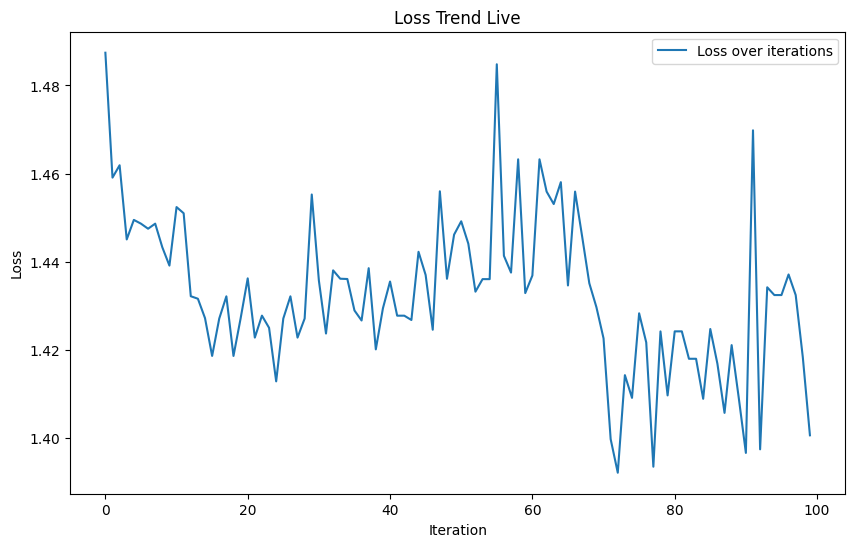

Optimized tokens: [18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 38, 13, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49]
Decoded optimized tokens: First Citizen:
Before we proceed ZAy further, hear me speak
Generation with prompt:
First Citizen:
Before we proceed ZAy further, hear me speak,
I make that foul little to up yours.

Second ROS:
Amend, do.
Are eyes noble spek, the shew-hiard b


In [32]:
def update_plot(losses):
    clear_output(wait=True)  # Clear the output of the current cell receiving output
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Loss over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Trend Live')
    plt.legend()
    display(plt.gcf())  # Display the current figure
    plt.close()  # Close the figure to prevent it from being displayed again in the notebook

def optimize_prefix(model, prefix_tokens, control_tokens, suffix_tokens, num_iterations, top_k, device):
    seq = torch.cat((prefix_tokens, control_tokens, suffix_tokens[:-1])).to(device)
    embed_weights = model.token_embeddings.weight
    prefix_length = prefix_tokens.size(0)
    control_length = control_tokens.size(0)
    suffix_length = suffix_tokens.size(0)
    losses = []

    for i in range(num_iterations):
        one_hot = F.one_hot(seq, num_classes=vocab_size).to(device=device, dtype=embed_weights.dtype)
        one_hot.requires_grad_()
        input_embeds = (one_hot @ embed_weights).unsqueeze(0)

        model.eval()
        logits = forward_with_tok_emb(model, input_embeds)

        loss = F.cross_entropy(logits[:, -suffix_length:, :].reshape(-1, vocab_size), suffix_tokens)
        losses.append(loss.item())
        update_plot(losses)

        model.zero_grad()
        loss.backward()

        grad = one_hot.grad.squeeze(0)[prefix_length:prefix_length+control_length]
        top_indices = (-grad).topk(top_k, dim=1).indices
        original_seq = seq.repeat(control_length, 1)
        new_token_val = torch.gather(top_indices, 1, torch.randint(0, top_k, (control_length, 1), device=device))
        new_token_pos = torch.arange(prefix_length, prefix_length+control_length, 1, device=grad.device).type(torch.int64)
        candidate_seqs = original_seq.scatter_(1, new_token_pos.unsqueeze(-1), new_token_val)

        model.eval()
        candidate_input_embeds = F.one_hot(candidate_seqs, num_classes=vocab_size).to(dtype=embed_weights.dtype) @ embed_weights
        candidate_logits = forward_with_tok_emb(model, candidate_input_embeds)

        targets = suffix_tokens.repeat(candidate_seqs.size(0), 1)
        individual_losses = F.cross_entropy(candidate_logits[:, -suffix_length:, :].transpose(1,2), targets, reduction='none')
        individual_losses = individual_losses.mean(dim=-1)

        min_loss_idx = torch.argmin(individual_losses)

        seq = candidate_seqs[min_loss_idx]

    return seq

# Set the prompt and suffix
prefix = "First Citizen:\nBefore we proceed "
control = "!!!"
suffix = " further, hear me speak."

prefix_tokens = encode(prefix)
prefix_tokens = torch.tensor(prefix_tokens, device=device)
control_tokens = encode(control)
control_tokens = torch.tensor(control_tokens, device=device)
suffix_tokens = encode(suffix)
suffix_tokens = torch.tensor(suffix_tokens, device=device)

# Set the optimization parameters
num_iterations = 100
top_k = 5

# Optimize the prefix
optimized_tokens = optimize_prefix(model, prefix_tokens, control_tokens, suffix_tokens, num_iterations, top_k, device)

print("Optimized tokens:", optimized_tokens.tolist())
print("Decoded optimized tokens:", decode(optimized_tokens.tolist()))
print("Generation with prompt:")
print(decode(model.generate(optimized_tokens.unsqueeze(0), max_new_tokens=100)[0].tolist()))